In [1]:
import os
from pathlib import Path
from collections import Counter

import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory

In [2]:
# !pip install -e /pollock

In [3]:
%load_ext autoreload
%autoreload 2

## collect data for module training

In [4]:
data_map = {
    'aml': '/data/single_cell_classification/tumor/aml',
    'br': '/data/single_cell_classification/tumor/BR/raw/houxiang_brca/merged.h5ad',
    'ccrcc': '/data/single_cell_classification/tumor/CCRCC/yige/adata.h5ad',
    'cesc': '/data/single_cell_classification/tumor/CESC/cesc.h5ad',
    'gbm': '/data/single_cell_classification/tumor/gbm/gbm.h5ad',
    'hnscc': '/data/single_cell_classification/tumor/HNSC/processed.h5ad',
    'melanoma': '/data/single_cell_classification/tumor/melanoma/melanoma.h5ad',
    'myeloma': '/data/single_cell_classification/tumor/myeloma/processed.h5ad',
    'pdac': '/data/single_cell_classification/tumor/PDAC/pdac.h5ad',
    'pdac_caf': '/data/single_cell_classification/tumor/PDAC/pdac_caf_subtypes.h5ad',
    'zheng_sorted': '/data/single_cell_classification/scRNAseq_benchmark/Intra-dataset/\
Zheng sorted/zheng_sorted.h5ad'
}

In [5]:
# adata_map = {}
# for k, fp in data_map.items():
#     print(k)
#     try:
#         adata_map[k] = sc.read_h5ad(fp)
#     except OSError:
#         print(f'{k} failed')

In [6]:
# ## check for cell_type key
# for k, adata in adata_map.items(): print(k, 'cell_type' in adata.obs.columns)

## iterate through and train modules

## 3. train pollock module

specify a location to save the trained pollock module

In [7]:
module_type = 'zheng_sorted'
run_name = f'{module_type}_v0.1.0'

In [8]:
module_save_filepath = f'/models/modules/{run_name}'
Path(module_save_filepath).mkdir(parents=True, exist_ok=True)

here we create a new anndata object from our processed anndata object

scanpy expects the raw counts data to be in the X attribute

In [9]:
train_adata = sc.read_h5ad(data_map[module_type])
train_adata

AnnData object with n_obs × n_vars = 20000 × 21952
    obs: 'cell_type'

In [10]:
# train_adata = train_adata[train_adata.obs['cell_type']!= 'Unknown']
# train_adata = train_adata[train_adata.obs['cell_type']!= 'CD34+CYTL1+']
# train_adata = train_adata[train_adata.obs['cell_type']!= 'Plasma_BM']
# train_adata

take a look at our cell counts

In [11]:
Counter(train_adata.obs['cell_type']).most_common()

[('CD14+ Monocyte', 2000),
 ('CD19+ B', 2000),
 ('CD34+', 2000),
 ('CD4+ T Helper2', 2000),
 ('CD4+/CD25 T Reg', 2000),
 ('CD4+/CD45RA+/CD25- Naive T', 2000),
 ('CD4+/CD45RO+ Memory', 2000),
 ('CD56+ NK', 2000),
 ('CD8+ Cytotoxic T', 2000),
 ('CD8+/CD45RA+ Naive Cytotoxic', 2000)]

initialize PollockDataset

In [12]:
pds = PollockDataset(train_adata, cell_type_key='cell_type', n_per_cell_type=1500,
                    dataset_type='training')

2020-06-11 14:26:03,426 normalizing counts for model training
2020-06-11 14:26:05,781 scaling data
2020-06-11 14:26:14,299 creating tf datasets


In [13]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.0001, latent_dim=25)

In [14]:
pm.fit(pds, epochs=50, max_metric_batches=2, metric_epoch_interval=1,
      metric_n_per_cell_type=50)

2020-06-11 14:26:35,940 epoch: 1, train loss: 39.74922561645508, val loss: 31.79314422607422
2020-06-11 14:26:44,715 epoch: 2, train loss: 38.732749938964844, val loss: 28.968870162963867
2020-06-11 14:26:53,671 epoch: 3, train loss: 38.45946502685547, val loss: 28.666976928710938
2020-06-11 14:27:02,432 epoch: 4, train loss: 38.30762481689453, val loss: 28.559814453125
2020-06-11 14:27:11,089 epoch: 5, train loss: 38.152496337890625, val loss: 28.47380256652832
2020-06-11 14:27:19,542 epoch: 6, train loss: 38.06180191040039, val loss: 28.456823348999023
2020-06-11 14:27:28,359 epoch: 7, train loss: 37.98326873779297, val loss: 28.391109466552734
2020-06-11 14:27:37,028 epoch: 8, train loss: 37.88238525390625, val loss: 28.354135513305664
2020-06-11 14:27:45,719 epoch: 9, train loss: 37.80764389038086, val loss: 28.335163116455078
2020-06-11 14:27:54,261 epoch: 10, train loss: 37.73643493652344, val loss: 28.32427406311035
2020-06-11 14:28:02,660 epoch: 11, train loss: 37.6689186096191

In [16]:
pm.save(pds, module_save_filepath)

## 4. module performance

visualize the overlap between groundtruth vs predicted cell types

Text(32.999999999999986, 0.5, 'Groundtruth')

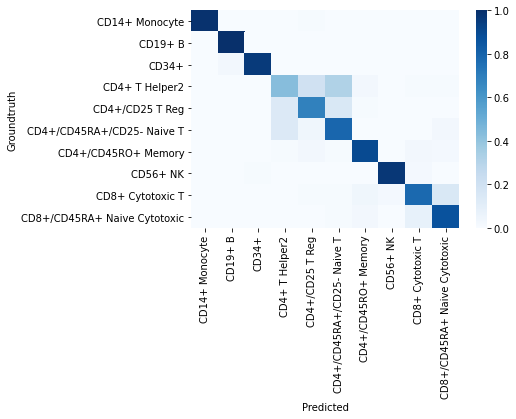

In [17]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

plot loss and accuracy for training and validation sets during training

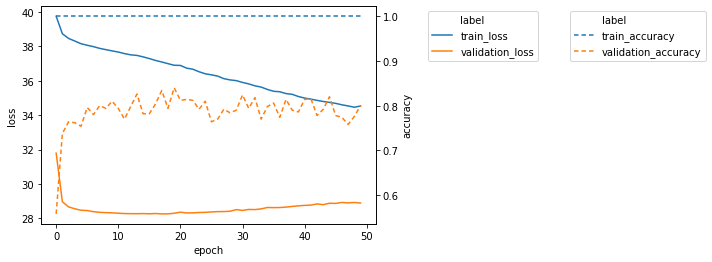

In [18]:
loss, label, epoch = [], [], []
for k in ['train_loss', 'validation_loss']:
    loss += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
    epoch += list(range(len(pm.summary['history'][k])))
df = pd.DataFrame.from_dict({'label': label, 'loss': loss, 'epoch': epoch})

sns.lineplot(x='epoch', y='loss', data=df, hue='label')
plt.legend(bbox_to_anchor=(1.5, 1))

accuracy, label = [], []
for k in ['train_accuracy', 'validation_accuracy']:
    accuracy += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
df = pd.DataFrame.from_dict({'label': label, 'accuracy': accuracy, 'epoch': epoch})

ax2 = plt.twinx()
sns.lineplot(x='epoch', y='accuracy', data=df, hue='label', ax=ax2, style='label',
                 dashes=[(3,2), (3,2)])
plt.legend(bbox_to_anchor=(2., 1))

plot validation loss broken down by cell type

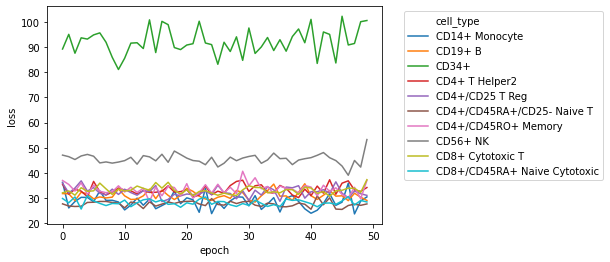

In [19]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_loss']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'loss': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='loss', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

plot validation accuracy for each cell type during training

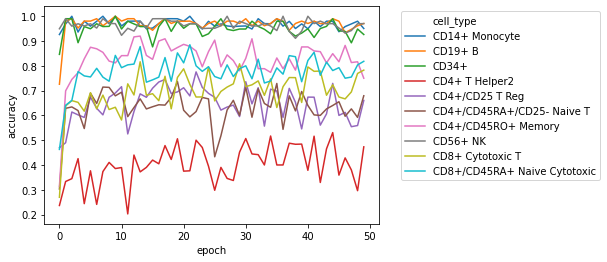

In [20]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_f1']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'accuracy': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='accuracy', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

## 5. retrain module for optimal number of epochs

from the above plots it apperas that the optimal training time is ~45 epochs for this dataset

In [21]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.0001, latent_dim=25)

In [22]:
pm.fit(pds, epochs=18, max_metric_batches=5, metric_epoch_interval=1,
      metric_n_per_cell_type=50)

2020-06-11 14:38:55,316 epoch: 1, train loss: 39.737937927246094, val loss: 30.482219696044922
2020-06-11 14:39:03,868 epoch: 2, train loss: 38.732749938964844, val loss: 27.83962631225586
2020-06-11 14:39:11,931 epoch: 3, train loss: 38.473670959472656, val loss: 27.568017959594727
2020-06-11 14:39:20,161 epoch: 4, train loss: 38.31977081298828, val loss: 27.44452476501465
2020-06-11 14:39:28,577 epoch: 5, train loss: 38.180118560791016, val loss: 27.412744522094727
2020-06-11 14:39:36,895 epoch: 6, train loss: 38.056907653808594, val loss: 27.345935821533203
2020-06-11 14:39:45,380 epoch: 7, train loss: 37.96003341674805, val loss: 27.304153442382812
2020-06-11 14:39:53,780 epoch: 8, train loss: 37.89226150512695, val loss: 27.282251358032227
2020-06-11 14:40:02,213 epoch: 9, train loss: 37.773399353027344, val loss: 27.24289894104004
2020-06-11 14:40:10,630 epoch: 10, train loss: 37.73700714111328, val loss: 27.228933334350586
2020-06-11 14:40:18,865 epoch: 11, train loss: 37.660293

In [23]:
pm.save(pds, module_save_filepath)

Text(32.999999999999986, 0.5, 'Groundtruth')

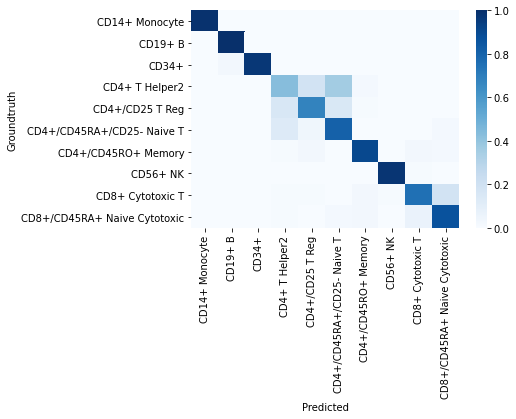

In [24]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

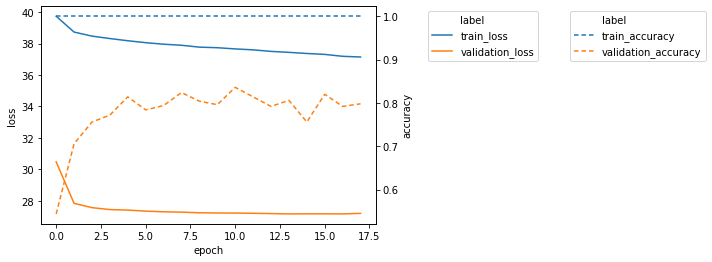

In [25]:
loss, label, epoch = [], [], []
for k in ['train_loss', 'validation_loss']:
    loss += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
    epoch += list(range(len(pm.summary['history'][k])))
df = pd.DataFrame.from_dict({'label': label, 'loss': loss, 'epoch': epoch})

sns.lineplot(x='epoch', y='loss', data=df, hue='label')
plt.legend(bbox_to_anchor=(1.5, 1))

accuracy, label = [], []
for k in ['train_accuracy', 'validation_accuracy']:
    accuracy += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
df = pd.DataFrame.from_dict({'label': label, 'accuracy': accuracy, 'epoch': epoch})

ax2 = plt.twinx()
sns.lineplot(x='epoch', y='accuracy', data=df, hue='label', ax=ax2, style='label',
                 dashes=[(3,2), (3,2)])
plt.legend(bbox_to_anchor=(2., 1))

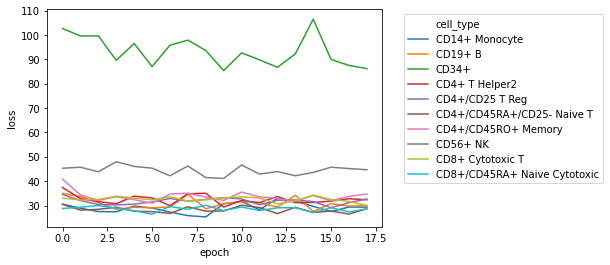

In [26]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_loss']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'loss': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='loss', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

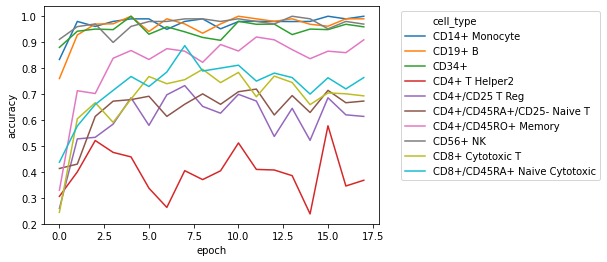

In [27]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_f1']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'accuracy': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='accuracy', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

In [28]:
train_adata = sc.read_h5ad(data_map[module_type])

In [29]:
loaded_pds, loaded_pm = load_from_directory(train_adata, module_save_filepath, )

2020-06-11 14:41:37,218 normalizing counts for prediction
2020-06-11 14:41:37,220 filtering for genes in training set
2020-06-11 14:41:37,230 0 genes in training set are missing from prediction set
/miniconda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-06-11 14:41:45,063 scaling data


In [30]:
labels, probs, cell_type_probs = loaded_pm.predict_pollock_dataset(loaded_pds, labels=True, )
labels[:5], probs[:5]

(('CD14+ Monocyte',
  'CD14+ Monocyte',
  'CD14+ Monocyte',
  'CD14+ Monocyte',
  'CD14+ Monocyte'),
 (0.99, 1.0, 0.75, 0.95, 1.0))

In [31]:
train_adata.obs['annotated_cell_type'] = train_adata.obs['cell_type'].to_list()
train_adata.obs['predicted_cell_type'] = list(labels)
train_adata.obs['predicted_probablility'] = list(probs)

In [32]:
cell_embeddings = loaded_pm.get_cell_embeddings(loaded_pds.prediction_ds)
cell_embeddings.shape, cell_embeddings

((20000, 25),
 array([[ 0.12002958,  0.6798295 , -0.15944123, ...,  0.54739755,
          0.4282745 , -0.5665861 ],
        [ 0.37588578,  0.40553555, -0.11718427, ...,  0.9596057 ,
          0.06016747, -0.26202285],
        [-1.9678625 , -0.3184867 ,  3.9735718 , ...,  4.3925986 ,
         -0.43854016,  5.152386  ],
        ...,
        [ 1.1287081 , -0.04048992, -0.56027687, ...,  1.546923  ,
         -0.62978   , -1.102673  ],
        [ 2.0490458 , -0.2895724 , -0.69864285, ...,  1.3986773 ,
         -0.28721815, -1.7467633 ],
        [ 1.2913834 , -0.04217779, -0.82795763, ...,  1.0568918 ,
         -0.3815163 , -1.5081244 ]], dtype=float32))

In [33]:
train_adata.obsm['cell_embeddings'] = cell_embeddings
sc.pp.neighbors(train_adata, use_rep='cell_embeddings')
sc.tl.umap(train_adata)

... storing 'annotated_cell_type' as categorical
... storing 'predicted_cell_type' as categorical


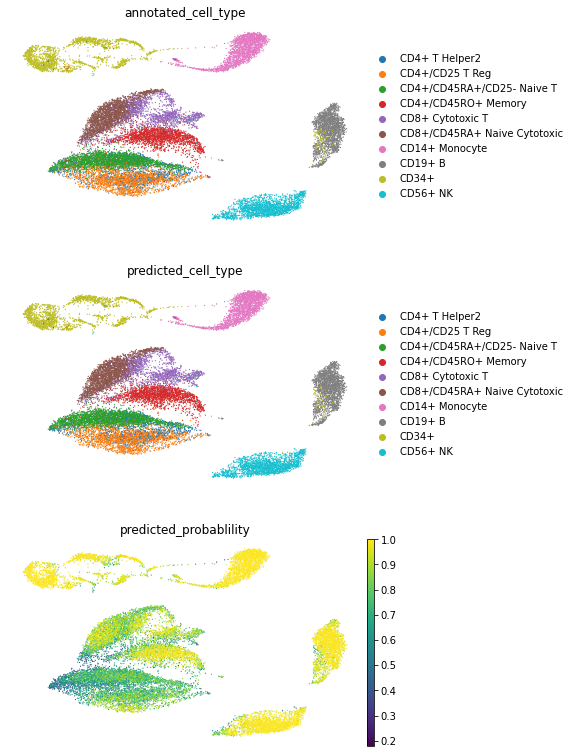

In [34]:
sc.pl.umap(train_adata, color=['annotated_cell_type', 'predicted_cell_type', 'predicted_probablility'],
          frameon=False, ncols=1)

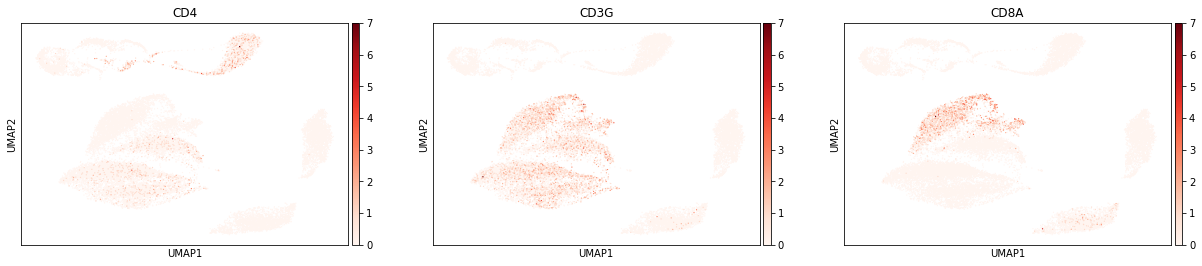

In [35]:
sc.pl.umap(train_adata, color=['CD4', 'CD3G', 'CD8A'], color_map='Reds')

In [36]:
pm.summary['validation']

{'metrics': {'CD14+ Monocyte': {'precision': 1.0,
   'recall': 0.988,
   'f1-score': 0.993963782696177,
   'support': 500},
  'CD19+ B': {'precision': 0.965183752417795,
   'recall': 0.998,
   'f1-score': 0.9813176007866273,
   'support': 500},
  'CD34+': {'precision': 0.9857142857142858,
   'recall': 0.966,
   'f1-score': 0.9757575757575758,
   'support': 500},
  'CD4+ T Helper2': {'precision': 0.574468085106383,
   'recall': 0.432,
   'f1-score': 0.4931506849315069,
   'support': 500},
  'CD4+/CD25 T Reg': {'precision': 0.7172995780590717,
   'recall': 0.68,
   'f1-score': 0.6981519507186859,
   'support': 500},
  'CD4+/CD45RA+/CD25- Naive T': {'precision': 0.6047904191616766,
   'recall': 0.808,
   'f1-score': 0.6917808219178082,
   'support': 500},
  'CD4+/CD45RO+ Memory': {'precision': 0.906187624750499,
   'recall': 0.908,
   'f1-score': 0.9070929070929071,
   'support': 500},
  'CD56+ NK': {'precision': 0.9879275653923542,
   'recall': 0.982,
   'f1-score': 0.9849548645937813,
 